In [6]:
%cd /Users/gwg/local/dmcm
%matplotlib inline

import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

import torch
from   torch import nn
from   torchvision.utils import save_image

from   data import GTExConfig, GTExDataset
from   models import AlexNetVAE
import plotutils

/Users/gwg/local/dmcm


In [2]:
cfg     = GTExConfig()
dataset = GTExDataset(cfg)

In [10]:
LATENT_DIM = 128
cfg.LATENT_DIM = LATENT_DIM
LR = '0.0001'
BETA = '5.0'

fname   = '/Users/gwg/local/dmcm/experiments/ivae/'\
          'gtex_dim-%s_lr-%s_epochs-6000_beta-%s' % (LATENT_DIM, LR, BETA)
state   = torch.load('%s/model.pt' % fname, map_location={'cuda:0': 'cpu'})
model   = AlexNetVAE(cfg)
model.load_state_dict(state)

Text(0.5,1,'Test KLD error')

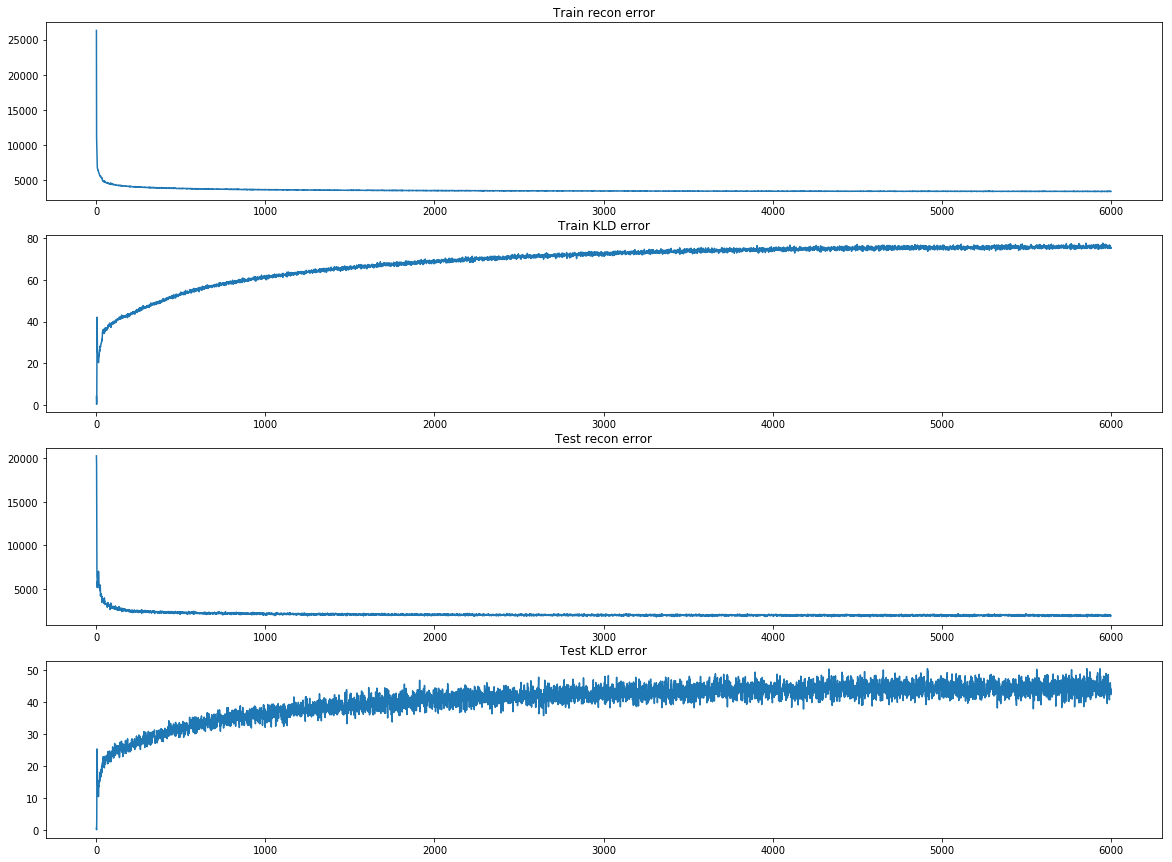

In [17]:
fpath   = '%s/out.txt' % fname
data    = np.array(plotutils.parse_vae_file(fpath))
# Remove the first N for visualization purposes.
N       = 0

x      = data[:, 0:1][N:]
rec_tr = data[:, 1:2][N:]
kld_tr = data[:, 2:3][N:]
rec_te = data[:, 3:4][N:]
kld_te = data[:, 4:5][N:]

fig, axs = plt.subplots(4, 1, figsize=(20, 15))

axs[0].plot(x, rec_tr)
axs[0].set_title('Train recon error')

axs[1].plot(x, kld_tr)
axs[1].set_title('Train KLD error')

axs[2].plot(x, rec_te)
axs[2].set_title('Test recon error')

axs[3].plot(x, kld_te)
axs[3].set_title('Test KLD error')

In [9]:
# for i in range(10):
#     sample = torch.randn(64, cfg.LATENT_DIM)
#     sample = model.decode(sample)
#     img    = sample.view(64, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
#     save_image(img, '/Users/gwg/Desktop/fantasy/sample_%s.png' % i)

# N_SAMPLES  = 2221
# N_Zs_PER_X = 1

# Zs = torch.Tensor(N_SAMPLES, LATENT_DIM)
# for i in range(N_SAMPLES):
#     if i % 250 == 0: print(i)
#     Zi = torch.Tensor(N_Zs_PER_X, LATENT_DIM)
#     for j in range(N_Zs_PER_X):
#         img = dataset.sample_ith_image(i)
#         z, _, mu, _ = model.forward(img.unsqueeze(0))
#         mu = mu.detach()
#         mu[j] = mu.squeeze(1)  # Remove batch
#     Zi_avg = mu.mean(dim=0)
#     assert Zi_avg.shape == (LATENT_DIM,)
#     Zs[i] = Zi_avg

# Zs = Zs.numpy()
# comp_mode = 'pca' if LATENT_DIM > 2 else None
# print('Compression mode: %s' % comp_mode)

# dataset.labels = dataset.labels[:N_SAMPLES]
# dataset.images = dataset.images[:N_SAMPLES]

# plotutils.plot_both_embeddings([Zs], dataset=dataset, 
#                                comp_mode=comp_mode,
#                                zoom=0.05,
#                                frameon=False)

In [26]:
for j in range(10):

    origin   = torch.randn(1, cfg.LATENT_DIM)
    batch    = torch.Tensor(64, cfg.LATENT_DIM)
    batch[0] = origin

    pos   = np.random.randn()
    delta = 0
    INC   = 0.02
    for i in range(63):
        if pos:
            delta += INC
        else:
            delta -= INC
        batch[i+1] = origin + delta

    sample = model.decode(batch)
    img    = sample.view(64, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
    save_image(img, '/Users/gwg/Desktop/fantasy/%s.png' % j)

In [44]:
p_of_zs = []
for i in range(5000):
    
    r = np.random.randint(0, 2221)
    img, _ = dataset[r]
    img = img.unsqueeze(0)
    z, _, _, _ = model.forward(img)
    
    z = z.detach().numpy()
    p_of_z = multivariate_normal.pdf(z, mean=np.zeros(128), cov=np.ones(128))

fantasy_mean = np.array(p_of_z).mean()

p_of_zs = []
for i in range(5000):
    z = np.random.randn(128)
    p_of_z = multivariate_normal.pdf(z, mean=np.zeros(128), cov=np.ones(128))
    p_of_zs.append(p_of_z)
    
real_mean = np.array(p_of_zs).mean()

print(real_mean / fantasy_mean)

14992.0708077


In [13]:
major = []
minor = []
means = np.zeros(LATENT_DIM)
covs  = np.ones(LATENT_DIM)

tissues = {
    'Fallopian Tube': 4,
    'Bladder': 4,
    'Adipose Tissue': 5,
    'Breast': 5,
    'Cervix Uteri': 7,
    'Nerve': 9,
    'Salivary Gland': 10,
    'Kidney': 12,
    'Vagina': 17,
    'Skin': 28,
    'Testis': 44,
    'Blood Vessel': 47,
    'Pituitary': 51,
    'Prostate': 53,
    'Small Intestine': 59,
    'Thyroid': 65,
    'Uterus': 69,
    'Lung': 76,
    'Colon': 81,
    'Ovary': 88,
    'Spleen': 103,
    'Stomach': 106,
    'Liver': 115,
    'Adrenal Gland': 134,
    'Esophagus': 134,
    'Pancreas': 166,
    'Brain': 172,
    'Heart': 188,
    'Muscle': 369,
}

with torch.no_grad():
    for tiss, count in tissues.items():
        probs = []
        for i in range(len(dataset)):
            if tiss != dataset.tissues[i]:
                continue

            img, _     = dataset[i]
            z, _, _, _ = model.forward(img.unsqueeze(0))
            p_of_z     = multivariate_normal.pdf(z, mean=means, cov=covs)
            probs.append(p_of_z)

        mean = np.array(probs).mean()
        print('p(%s) mean: %s' % (tiss, mean))
        
        tissues[tiss] = (count, mean)
        
sorted_by_prob = sorted(tissues.items(), key=lambda kv: kv[1][1])
print(sorted_by_prob)

p(Fallopian Tube) mean: 1.75733648245e-77
p(Bladder) mean: 3.22752944717e-73
p(Adipose Tissue) mean: 1.19025962543e-76
p(Breast) mean: 3.72110677646e-77
p(Cervix Uteri) mean: 8.01507348871e-75
p(Nerve) mean: 6.92518775092e-73
p(Salivary Gland) mean: 2.80565592044e-73
p(Kidney) mean: 2.18675982128e-73
p(Vagina) mean: 9.14891265849e-73
p(Skin) mean: 1.99211675908e-72
p(Testis) mean: 3.07274484394e-72
p(Blood Vessel) mean: 7.27197635265e-73
p(Pituitary) mean: 2.49240256054e-72
p(Prostate) mean: 4.23160811426e-74
p(Small Intestine) mean: 2.29024716844e-74
p(Thyroid) mean: 1.76602178519e-74
p(Uterus) mean: 3.66977913367e-74
p(Lung) mean: 4.92755661202e-70
p(Colon) mean: 6.90088344056e-72
p(Ovary) mean: 6.87089451236e-71
p(Spleen) mean: 1.19730864396e-73
p(Stomach) mean: 6.51133157105e-71
p(Liver) mean: 5.13885975577e-72
p(Adrenal Gland) mean: 9.97769007429e-71
p(Esophagus) mean: 2.16770310797e-73
p(Pancreas) mean: 6.11023292008e-72
p(Brain) mean: 8.4551727319e-74
p(Heart) mean: 4.9892902807

        Fallopian Tube | 4 | 1
        Adipose Tissue | 5 | 6
        Vagina | 17 | 15
        Cervix Uteri | 7 | 483
        Blood Vessel | 47 | 675
        Prostate | 53 | 926
        Bladder | 4 | 9606
        Colon | 81 | 10588
        Muscle | 369 | 14791
        Uterus | 69 | 16472
        Small Intestine | 59 | 19796
        Breast | 5 | 26796
        Spleen | 103 | 31756
        Nerve | 9 | 38400
        Pituitary | 51 | 59239
        Kidney | 12 | 72601
        Brain | 172 | 103000
        Esophagus | 134 | 105560
        Lung | 76 | 280483
        Stomach | 106 | 521776
        Ovary | 88 | 733971
        Salivary Gland | 10 | 739142
        Pancreas | 166 | 1398898
        Thyroid | 65 | 2523793
        Testis | 44 | 3615377
        Heart | 188 | 6643331
        Liver | 115 | 6917016
        Skin | 28 | 7119536
        Adrenal Gland | 134 | 12851013


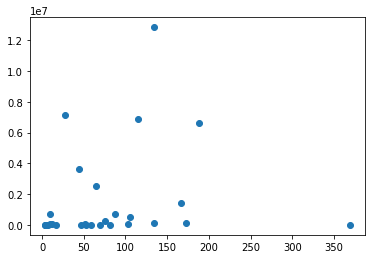

In [18]:
sorted_by_prob = [('Fallopian Tube', (4, 1.3613122706985203e-77)), ('Adipose Tissue', (5, 8.5682370239702753e-77)), ('Vagina', (17, 2.0489652868104652e-76)), ('Cervix Uteri', (7, 6.5819208442565754e-75)), ('Blood Vessel', (47, 9.1825703035457092e-75)), ('Prostate', (53, 1.2609244946199002e-74)), ('Bladder', (4, 1.3076947228479155e-73)), ('Colon', (81, 1.4413563059796374e-73)), ('Muscle', (369, 2.0135555089282114e-73)), ('Uterus', (69, 2.2424206168467134e-73)), ('Small Intestine', (59, 2.694921206960645e-73)), ('Breast', (5, 3.6477043368019132e-73)), ('Spleen', (103, 4.3229851915722756e-73)), ('Nerve', (9, 5.2274180955091496e-73)), ('Pituitary', (51, 8.0643449728079562e-73)), ('Kidney', (12, 9.8832879239987065e-73)), ('Brain', (172, 1.4021459717314939e-72)), ('Esophagus', (134, 1.4369950689359855e-72)), ('Lung', (76, 3.8182525423234249e-72)), ('Stomach', (106, 7.1030001651293806e-72)), ('Ovary', (88, 9.9916322670635956e-72)), ('Salivary Gland', (10, 1.0062036587240546e-71)), ('Pancreas', (166, 1.9043374503491229e-71)), ('Thyroid', (65, 3.4356704581323728e-71)), ('Testis', (44, 4.9216564757008766e-71)), ('Heart', (188, 9.0436483475692789e-71)), ('Liver', (115, 9.4162191789057867e-71)), ('Skin', (28, 9.6919117976654958e-71)), ('Adrenal Gland', (134, 1.7494241835747377e-70))]
min_ = sorted_by_prob[0][1][1]

xs = []
ys = []
for tpl in sorted_by_prob:
    tiss  = tpl[0]
    count = tpl[1][0]
    norm  = round(tpl[1][1] / min_)
    print('        %s | %s | %s' % (tiss, count, norm))
    
    xs.append(count)
    ys.append(norm)
    
plt.scatter(xs, ys)